# Healpix allsky

We show how to combine the [healpix](http://healpix.jpl.nasa.gov) scheme with `cygrid`, using the `healpy` package. We will generate a simulated, full-sky data set and grid it onto a smaller fits image.

We start by adjusting the notebook settings.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We attempt to limit our dependencies as much as possible, but [`astropy`](https://astropy.readthedocs.org/en/stable/),  [`healpy`](http://healpy.readthedocs.org), and [`wcsaxes`](http://wcsaxes.readthedocs.org) needs to be available on your machine if you want to re-run the calculations. We can highly recommend [`anaconda`](https://www.continuum.io/downloads) as a scientific `python` platform.

In [8]:
import numpy as np
import matplotlib.pyplot as pl

import healpy as hp
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

import cygrid

Let's define some plotting `kwargs` for the images.

In [9]:
imkw = dict(
    origin='lower',
    interpolation='None')

We start off by setting the basic healpix parameters which will define our coordinate system. It's given entirely by the `nside`. For more details, check the paper by [Gorski et al. (2005)](http://adsabs.harvard.edu/abs/2005ApJ...622..759G). We stick to ring-ordering throughout this notebook.

In [10]:
NSIDE = 1024
NPIX = hp.nside2npix(NSIDE)
LMAX = 1024

To generate a simulated fullsky map, we set up some power law and use healpy to create an image based on this.

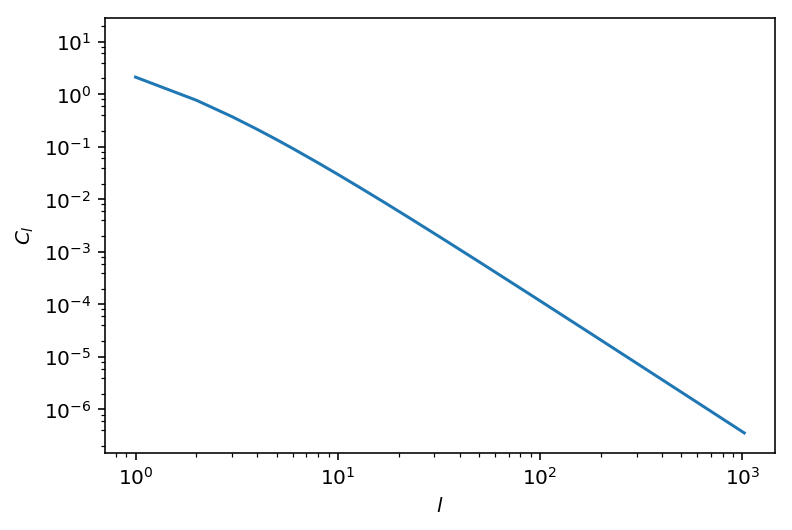

In [11]:
power = (lambda k: 12 / (k + 1) ** 2.5)
cl = power(np.arange(LMAX))
pl.loglog(cl)
pl.xlabel(r'$l$')
pl.ylabel(r'$C_l$')

The `random_field` is easily generated by using `hp.synfast`.

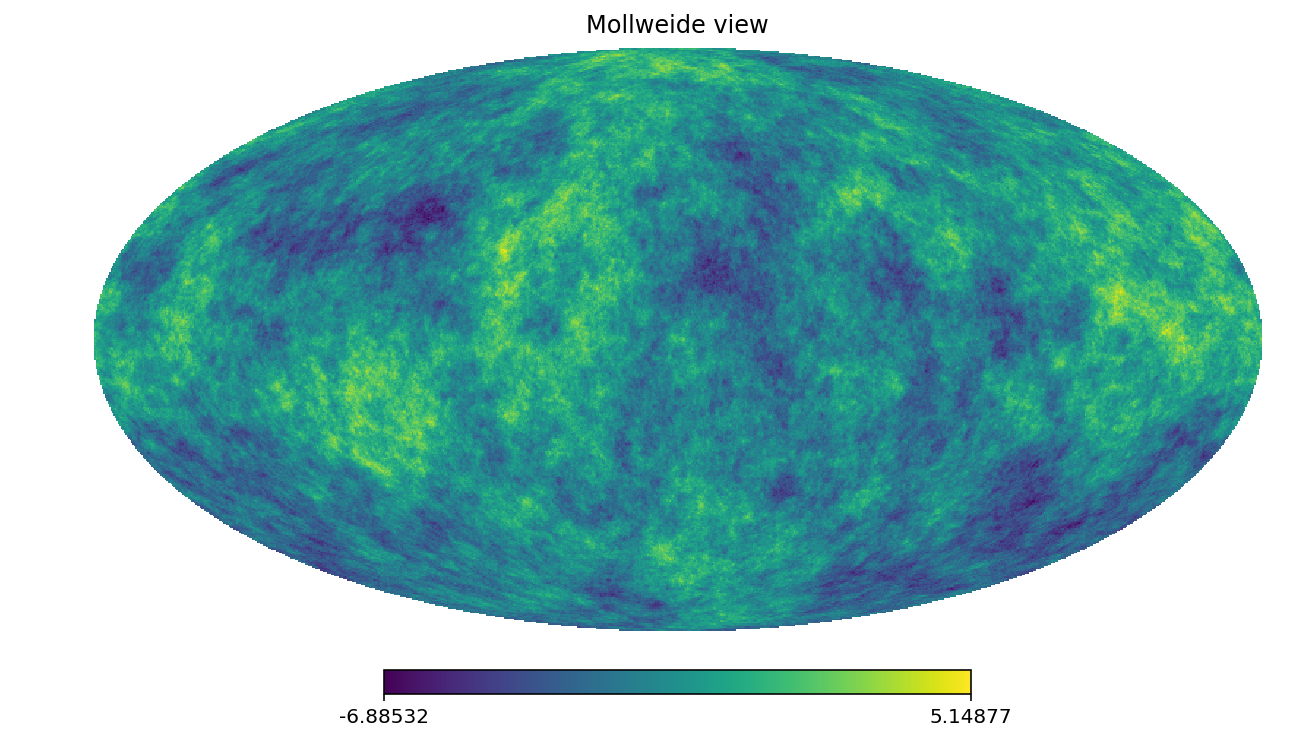

In [12]:
random_field = hp.synfast(cl, NSIDE, verbose=False)
hp.mollview(random_field)

We manually create the `header` onto which we will grid the data. You need to make sure that all the celestial information are available and that the header is three-dimensional.

In [13]:
header = fits.Header()

pixsize = 3.5/60.

header['SIMPLE'] = 'T'
header['BITPIX'] = -32
header['NAXIS'] = 3

header['NAXIS1'] = 250
header['NAXIS2'] = 250
header['NAXIS3'] = 1

header['CDELT1'] = -pixsize
header['CDELT2'] = pixsize
header['CDELT3'] = 1.

header['CRPIX1'] = 0
header['CRPIX2'] = 0
header['CRPIX3'] = 0

header['CRVAL1'] = 180.
header['CRVAL2'] = 10.
header['CRVAL3'] = 0.
header['LATPOLE'] = 90.

header['CTYPE1'] = 'GLON'
header['CTYPE2'] = 'GLAT'
header['CTYPE3'] = 'VRAD'

wcs = WCS(header)

We start the gridding by initating the gridder with the `header`.

In [14]:
gridder = cygrid.WcsGrid(header)

Similar to the examples in previous notebooks, we need to define the coordinates for the input image. For healpix data, this is really straightforward and can easily be done with the `healpy` package.

In [15]:
theta, phi = hp.pix2ang(NSIDE, np.arange(NPIX))
lons = np.rad2deg(phi).astype(np.float64)
lats = (90. - np.rad2deg(theta)).astype(np.float64)

The gridding kernel is of key importance for the entire gridding process. `cygrid` allows you to specify the shape of the kernel (e.g. elliptical Gaussian or tapered sinc) and its size.

In our example, we use a symmetrical Gaussian (i.e. the major and minor axis of the kernel are identical). In that case, we need to furthermore specify `kernelsize_sigma`, the `sphere_radius` up to which the kernel will be computed, and the maximum acceptable healpix resolution for which we recommend `kernelsize_sigma/2`.

We refer to section 3.5 of the paper ('a minimal example') for a short discussion of the kernel parameters.

In [16]:
kernelsize_fwhm = 12./60. # 12 arcminutes
kernelsize_sigma = kernelsize_fwhm / 2.355 # https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sphere_radius = 3. * kernelsize_sigma

gridder.set_kernel(
    'gauss1d',
    (kernelsize_sigma,),
    sphere_radius,
    kernelsize_sigma / 2.
    )

After the kernel has been set, we perform the actual gridding by calling `grid()` with the coordinates and the data. Note that we need to add an artifical third axis to the `random_field`.

In [17]:
gridder.grid(lons, lats, random_field[:, None])

To get the gridded data, we simply call `get_datacube()`. We get rid of the degenerate third axis by using `squeeze()`.

In [18]:
datacube = gridder.get_datacube().squeeze()

And here is how our gridded field looks like.

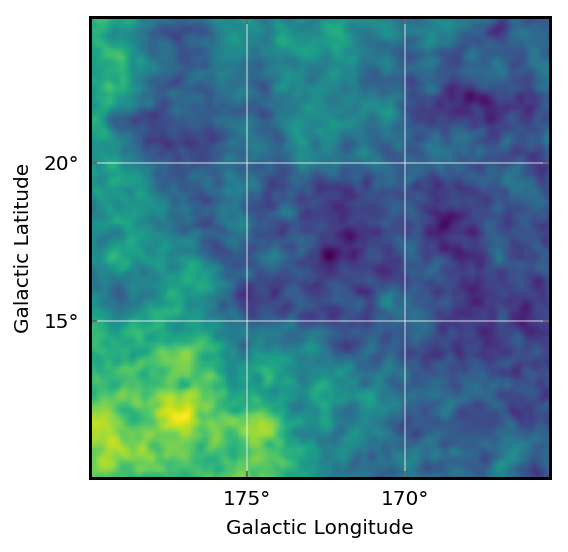

In [19]:
fig = pl.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs.celestial)
lon, lat = ax.coords
lon.set_axislabel('Galactic Longitude')
lat.set_axislabel('Galactic Latitude')
ax.imshow(datacube, **imkw)
ax.coords.grid(color='white', alpha=0.5, linestyle='solid')

Finally, we can write the fits-image to disk. To make it two-dimensional, we have to create a celestial header. The WCS module can take care of this.

In [65]:
cel_header = wcs.celestial.to_header()

In [66]:
fits.writeto('fullsky_regridded.fits', datacube, cel_header, clobber=True)